# LSTM all Data

Use a LSTM to predict of all store item combinations.

This is achieved by training a model on a sequence first. In a second step it is used for prediction. The weights are in initialized with the weights from the previous iteration. 
This procedure is compuationally expensive since it has to run 500 times.

## 0. Imports

In [1]:
## Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns

import torch
import torch.nn as nn
import torch.utils.data

from sklearn.preprocessing import StandardScaler

import random

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from pandas.plotting import register_matplotlib_converters

from IPython.display import clear_output

In [2]:
## Load data
file = "./data/train.csv"
data = pd.read_csv(file)
data["date"] = pd.to_datetime(data["date"])

## Split into train and testing data
## Use the last 3 month (Oct-Dec 2017) as testing data. The rest is training data.
train = data.loc[data['date'] < '2017-10-01' ]
test = data.loc[data['date'] >= '2017-10-01' ]

## 1. Data preparation
In a first step the data for the training and development dataset is extracted. The date information is the one-hot encoded. Finally, we generate sequencs whch can be used for training and testing.

### SMAPE score

The error is quantified using the *Symmetric Mean Average Percentage Error* (SMAPE). It is defined as

$SMAPE = \sum(\frac{\left| P - A \right|}{0.5 \cdot ( \left| A \right| + \left| P \right| )}) $


In [3]:
def SMAPE(pred, truth):
    
    smape = 0
    
    for i in range(len(pred)):
        
        smape += abs( pred[i] - truth[i] ) / (0.5*( abs(pred[i]) + abs(truth[i])) )
    
    smape = (100 / len(pred) ) * smape
    
    return smape

In [4]:
## Get one store and item
def get_sales_store_item(store, item):
    '''
    Returns train and test as datasets for selected store and item.
    '''
    
    train_ind = train.loc[train["store"] == store].loc[train["item"] == item]
    test_ind = test.loc[test["store"] == store].loc[test["item"] == item]
    
    return train_ind, test_ind

### 1.1 One hot encoding

One-hot encode year, month, day.

For a store item combination we will get a dataframe `12 + 7 + 1 = 20` dimensions, since the sales value is included.

In [5]:
def onehot_encode_store_item(df):
    '''
    One-hot encodes a store item combination.
    
    Inputs:
    df -- dataframe with dates and corresponding sales
        
    Returns:
    df -- dataframe with the one-hot encoded variables of dimension (df.shape[0], 21). Index is the date.
    '''
    
    ## Extract dates and sales from input dataframe
    dates = df['date'].tolist()
    sales = df['sales'].tolist()
    
    ### One-hot encode the month in two steps: integer - binary
    sequence = df['date'].dt.strftime("%m")

    ## integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(sequence)

    ## binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_month = onehot_encoder.fit_transform(integer_encoded)

    ## Initialize sub dataframe 1
    months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]       
    df_onehot_month = pd.DataFrame(0, index=df.index, columns=months)    
    
    # Differentiate training and testing case. For testing the one-hot encoded sequence has to be padded with 0s
    # to match the number of features from the training case.       
    if df.shape[0] >= 100:    
        i = 0
        for month in months:
            df_onehot_month[str(month)] = onehot_month[:, i]
            i += 1
        
    elif df.shape[0] < 100:
        for i in range(3):
            df_onehot_month[str(months[i])] = onehot_month[:, i]
        
    df_onehot_month.reset_index(inplace=True)
     
        
    ### One-hot encode day of the week in two steps: integer - binary
    sequence = df['date'].dt.dayofweek.astype("int")

    ## integer encode
    label_encoder = LabelEncoder()
    sequence = label_encoder.fit_transform(sequence)

    ## binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    sequence = sequence.reshape(len(sequence), 1)
    onehot_weekday = onehot_encoder.fit_transform(sequence)

    ## Initialize sub dataframe 2
    weekdays = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
    
    ## Format dataframe for output
    df_onehot_weekday = pd.DataFrame(0, index=df.index, columns=weekdays) 

    i = 0
    for weekday in weekdays:
        df_onehot_weekday[str(weekday)] = onehot_weekday[:, i]
        i += 1

    df_onehot_weekday.reset_index(inplace=True)
        
        
    ### Generate final output dataframe. Date as index, sales as last column.
    df = df_onehot_month.merge(df_onehot_weekday)
    del df["index"]
    df["date"] = dates
    df = df.set_index("date")
    df["sales"] = sales
    
    return df

### 1.2 Generate sequences

In [6]:
def make_sequences(data, window_size):
    '''
    Generates output sequences from a one-hot encoded dataframe.
    
    Inputs:    
    data -- one-hot encoded dataframe for a store, item combination. Dimensions: (num_samples, 21)
    window_size -- length of a training sequence
      
    Output:  
    sequence_out -- list of training data and labels as torch tensors according to given window size.
    '''
                
    sequence_out = []
    
    for i in range(len(data)-window_size-1):     

        train_sequence = np.array(data.iloc[i:i+window_size, :])
        train_label = np.array(data.iloc[i+window_size:i+window_size+1, -1]).reshape((-1, 1))          
        train_sequence = torch.tensor(train_sequence).float()
        train_label = torch.tensor(train_label).float()   
        
        sequence_out.append((train_sequence, train_label))
    
    return sequence_out

## 2. Define Net Topologie and Training Functions

In [7]:
## NET

class LSTM_basic(nn.Module):
    def __init__(self, input_size, hidden_size_1, output_size):
        super(LSTM_basic, self).__init__()
        self.hidden_size_1 = hidden_size_1
        self.output_size = output_size
        
        ## LSTM
        self.lstm = nn.LSTM(input_size, hidden_size_1, batch_first=False, dropout=0)
        
        ## Linear layers
        self.fc1 = nn.Linear(hidden_size_1, output_size)
     
        ## Non-linear layers
        self.out = nn.Sigmoid()

    def forward(self, x):
        
        ## Compute lstm output
        lstm_out, (h_out, _) = self.lstm(x)
        
        ## Unpack LSTM output
        # Dim: (seq_len, batch, num_directions*hidden_size)        
        x = lstm_out.squeeze()[-1, :]
    
        ## Linear layer
        x = self.fc1(x)
        
        return x

In [8]:
def train_model(train_sequence, store, item, model, epochs=30):
        
    ## Train
    loss_dict = {"Training loss":[], "Validation loss": [], "Training smape":[]}


    ## Set model to train (which is the default)
    model.train()

    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch+1, epochs))

        # Initialize lists for keeping track of loss and SMAPE during the epoch
        smape_sub = []
        loss_sub = []

        for X, Y in train_sequence:        
            X = torch.unsqueeze(X, 1)
            Y = Y.view(-1)

            ## Zero gradients
            optimizer.zero_grad()

            ## Forward pass 
            Y_hat = model(X)

            ## Compute loss      
            loss = loss_function(Y_hat, Y)

            ## Backporp
            loss.backward()

            ## Update
            optimizer.step()

            ## Evaluate prediction
            loss_sub.append(loss.item())
            smape_sub.append(SMAPE(Y_hat.detach().numpy(), Y.detach().numpy()))

        ## Evaluate training metric
        loss_dict["Training loss"].append(np.mean(loss_sub))

        ## Add SMPAE to dictionary
        loss_dict["Training smape"].append(np.mean(smape_sub))

        ## Use last sample for performance evaluation
        print("Training loss: {:.4f} | Training SMAPE: {:.4f}".format(np.mean(loss_sub), np.mean(smape_sub)))

    print("Training complete!")
    
    return model

In [9]:
## Prediction

def predict(test_sequence, store, item, model):

    _, sales_test = get_sales_store_item(store, item)
    df_onehot = onehot_encode_store_item(sales_test)
    test_sequence = make_sequences(df_onehot, window_size)

    pred = []
    truth = []

    model.eval()

    with torch.no_grad():

        for X, Y in test_sequence:        
            X = torch.unsqueeze(X, 1)
            Y_pred = model(X)
            pred.append(Y_pred.item())
            truth.append(Y.item())
            
    return pred, truth

## 3. Train and Predict

We now put everything together. We loop over each store item combination. The predictions are stored in a list so that they can be indexed afterwards.

To speed up training, the model is trained as follows: For a new store compute 10 epochs as warm-up. Taking these weights compute 15 epochs for the first item. For the second item use the weights from the previous item as initialization.

All samples are trained with a fixed learning rate of $0.0001$ and a `window_size` of $7$. Out of multiple variations these deliver the best results.

To simplify training the following is done:

- Stochastic gradient descent instead of mini batch gradient descent
- Fixed learning rate
- Small number of epochs

In [ ]:
## Topology
input_size = 20 # one feature namely sales
hidden_size_1 = 64 #arbitrary
output_size = 1 # one feature sales

## Hyperparameters
learning_rate = 0.0001
window_size = 7


names = []
df_predictions = pd.DataFrame()
df_truths = pd.DataFrame()

## Pretrain model with data from 1_1
model = LSTM_basic(input_size, hidden_size_1, output_size)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

sales_train, sales_test = get_sales_store_item(1, 1)
df_onehot = onehot_encode_store_item(sales_train)
train_sequence = make_sequences(df_onehot, window_size)
model = train_model(train_sequence, 1, 1, model, epochs=10) # 10
df_test = onehot_encode_store_item(sales_test)
test_sequence = make_sequences(df_test, window_size)


for store in np.arange(1, 11):
    for item in np.arange(1, 51):
        name = "Sales_" + str(store) + "_" + str(item)
        names.append(name)
        clear_output(wait=True)
        print("Training sample " + str(name[-1]))
        
        ## Get data
        sales_train, sales_test = get_sales_store_item(store, item)
        df_onehot = onehot_encode_store_item(sales_train)
        train_sequence = make_sequences(df_onehot, window_size)

        ## Initialize model
        #model = LSTM_basic(input_size, hidden_size_1, output_size)
        loss_function = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
        ## Train
        model = train_model(train_sequence, store, item, model, epochs=15) # 15
        
        ## Prediction
        pred, truth = predict(test_sequence, store, item, model)
    
        df_predictions[name] = pred
        df_truths[name] = truth
        
        ## Save dataframe
        df_predictions.to_csv("Predictions.csv")
        df_truths.to_csv("Testing_Sequences.csv")

## 4. Inspect results

We can now evaluate the performance of the LSTM.

In [11]:
## Load all predictions and test sequences

predictions = pd.read_csv("predictions/Predictions_LSTM.csv", index_col=0)
truth = pd.read_csv("data/Testing_Sequences_LSTM.csv", index_col=0)

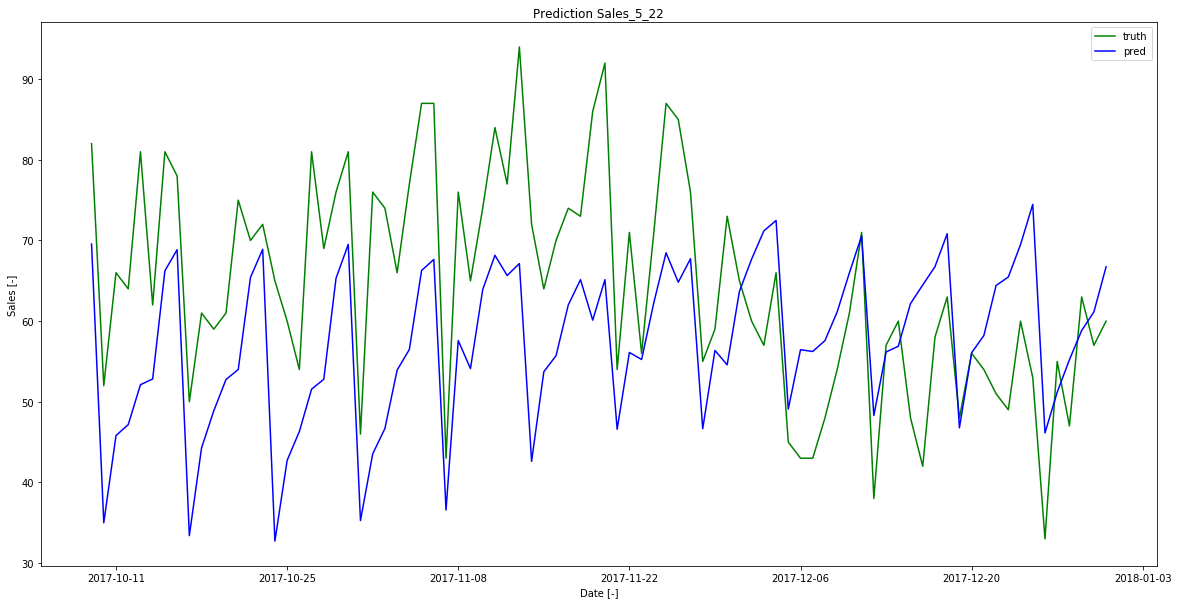

In [13]:
## Plots
name = "Sales_5_22"



## Get dates
_, sales_test = get_sales_store_item(1, 1)
dates = sales_test['date'][7+1:].tolist()

## Plot
plt.figure(figsize=[20,10])
plt.plot(dates, truth[name], color='green', label="truth")
plt.plot(dates, predictions[name], color='blue', label="pred")
plt.title("Prediction " + str(name))
plt.xlabel("Date [-]")
plt.ylabel("Sales [-]")
plt.legend()
plt.show()

In [19]:
## Compute Testing SMAPE
name = "Sales_1_40"

smapes = []

print("Number of store item combinations: " + str(predictions.shape[1]))
for i in range(predictions.shape[1]):
    
    smape = SMAPE(predictions.iloc[:, i], truth.iloc[:, i])
    smapes.append(smape)
    

print("Best SMAPE:  {:.2f}\nWorst SMAPE: {:.2f}".format(min(smapes), max(smapes)))
print("Average SMAPE: {:.2f}".format(np.mean(smapes)))

Number of store item combinations: 279
Best SMAPE:  13.48
Worst SMAPE: 127.97
Average SMAPE: 39.68


## 5. Conclusion

A LSTM has been used to predict the sales of 279 store item combinations (out of a total of 500). An average SMAPE of `40` has been achieved. The spread between SMAPEs for different sequences is quite large. The best score is around `13` whereas the worst is greater than `120`. This result could be improved with further hyper parameter tuning. In particular the number of epochs could be increased.

In the previous notebook `02_Statistical_Models` the statistical models `ARIMA` and `SARIMA` have been used on the same data. They achieved results which seem to be similar if not more accurate than the results produced here (an average SMAPE has not been computed and results are available for a small number of sequences). Given the time intensive procedures of setting up and tuning the LSTM, the simpler statistical models appear to be the better choice in this case.